In [1]:
import warnings
warnings.filterwarnings('ignore') 

import numpy as np
import pandas as pd
from collections import Counter
import cv2, os
from tqdm import tqdm
from random import shuffle
import shutil
import re
import datetime
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn import utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

from wandb.keras import WandbCallback
import imgaug.augmenters as iaa

# Importing Modules

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from data_generator import *
from functions_generator import *

In [4]:
#from customized_adaboost import AdaBoostClassifier as Ada_CNN


In [81]:
from truth_adaboost import AdaBoostClassifier as Ada_CNN


In [6]:
from constants import *

# Wandb

In [7]:
# For MLOps
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback
wandb.login(key='236eaeacc7d9dd51a618dca240c24e304f5ad256',relogin=True)

W&B:  0.13.5


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\UsuarioHI/.netrc


True

In [8]:
# Dataset EyeQ
train_quality = pd.read_csv(root_path + 'data/Label_EyeQ_train.csv')
test_quality = pd.read_csv(root_path + 'data/Label_EyeQ_test.csv' )

# Selecciono imágenes que sean gradables y usables
train_quality = train_quality.loc[(train_quality['quality']==0) | (train_quality['quality']==1)]

train_quality['Referible'] = np.where((train_quality['DR_grade']==0) | (train_quality['DR_grade']==1), 0, 1)

# Selecting images

In [9]:
# De aquellas imágenes que sean usables y calificables, seleccionar las primeras 5 por cada target de retinopatía
images_include = list(train_quality.loc[(train_quality['quality']==0) | (train_quality['quality']==1)].groupby('DR_grade').head(6)['image'].unique())


train_quality = train_quality.loc[train_quality['image'].isin(images_include)]

train_quality.groupby('Referible')['DR_grade'].value_counts()

Referible  DR_grade
0          0           6
           1           6
1          2           6
           3           6
           4           6
Name: DR_grade, dtype: int64

# Train test split

In [10]:
train_quality = train_quality.reset_index()
train_quality['ID'] = train_quality.image.apply(lambda x: re.findall(r'\d+', x)[0])

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

list_imgs = np.array(train_quality['image'])
list_labels = np.array(train_quality['Referible'])

groups = train_quality['ID']

# me aseguro que estén las imágenes de un solo paciente de un lado ó del otro
for i, (train_index, test_index) in enumerate(
        gss.split(train_quality['image'], train_quality['Referible'], groups=train_quality['ID'])):
    train_idx = train_index
    test_idx = test_index

print("Cantidad indices de train", len(train_index))
print("Cantidad indices de test", len(test_index))

X_train = train_quality.loc[train_quality.index.isin(train_idx)].image
y_train = train_quality.loc[train_quality.index.isin(train_idx)]['Referible']

X_test = train_quality.loc[train_quality.index.isin(test_idx)].image
y_test = train_quality.loc[train_quality.index.isin(test_idx)]['Referible']

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

Cantidad indices de train 19
Cantidad indices de test 11


In [11]:
training_generator = DataGeneratorNext(X_train, y_train, **params_train)
valid_generator = DataGeneratorNext(X_test, y_test, **params_valid)

In [12]:
np.unique(y_train)

array([0, 1])

In [13]:
img,target = next(training_generator)

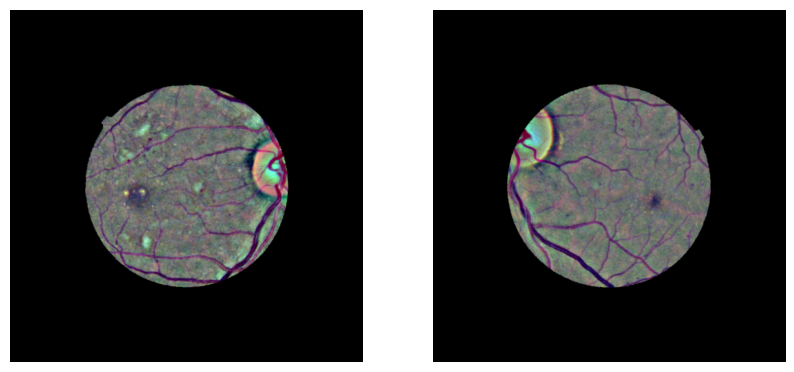

In [14]:
plt.figure(figsize=(10,6))
for i in range(len(img)):
    plt.subplot(1,2,i+1), plt.imshow(img[i])
    plt.axis('off')
plt.show()

# Model

In [15]:
def get_model(parameters):
    base_model = keras.applications.VGG16(
                                    weights=parameters['weights'],  
                                    input_shape=parameters['input_shape_model'],
                                    include_top=parameters['include_top'])

    base_model.trainable = parameters['trainable']


    # Freezing weights
    x = base_model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation=tf.nn.relu)(x)
    x = Dropout(parameters['dropout'])(x)
    x = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
    x = Dropout(parameters['dropout'])(x)
    outputs = tf.keras.layers.Dense(1, activation=parameters['output_activation'])(x)
    model = keras.Model(inputs=base_model.input, outputs=outputs)

    return model

# Probar por separado Adaboost customized

In [37]:
n_estimators=10
epochs=1
bdt_real_test_CNN = Ada_CNN(
    base_estimator=get_model(params),
    n_estimators=n_estimators,
    learning_rate=1,
    epochs=epochs)

In [22]:
X1,y1 = next(training_generator)

(2, 512, 512, 3)


In [23]:
n_samples = X1.shape[0]

In [24]:
n_samples

2

In [104]:
sample_weight = np.ones(n_samples) / n_samples

In [26]:
sample_weight

array([0.5, 0.5])

In [97]:
base_estimator0 = get_model(params)

In [28]:
from keras.models import Sequential

In [98]:
config=base_estimator0.get_config()
#estimator = Models.model_from_config(config)
estimator1 = Sequential.from_config(config)


weights = base_estimator0.get_weights()
estimator1.set_weights(weights)
estimator1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
from sklearn.preprocessing import LabelBinarizer


In [31]:
lb=LabelBinarizer()
y_b = lb.fit_transform(y1)

Hace el fit en el sample training (batch) por cada n_estimator

In [100]:
estimator1.fit(X1, y_b, sample_weight=sample_weight, epochs = 1, batch_size = 2)

1/1 [==============================] - 6s 6s/step - loss: 0.2958 - accuracy: 0.5000


In [117]:
y_pred = estimator1.predict(X1) # 2 imgs, 2 predictions


1/1 [==============================] - 1s 1s/step


In [119]:
y_b

array([[0],
       [1]])

In [118]:
y_pred

array([[0.33740652],
       [0.32109648]], dtype=float32)

In [102]:
y_pred_l = np.where(y_pred>0.5,1,0)
incorrect = y_pred_l != y_b
estimator_error = np.dot(incorrect.reshape(1,-1), sample_weight) / np.sum(sample_weight, axis=0)


In [103]:
estimator_error

array([0.50028561])

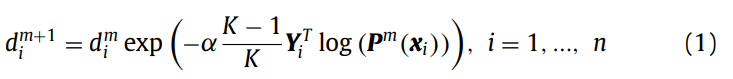

In [106]:
from numpy.core.umath_tests import inner1d
sample_weight = sample_weight*np.exp(-1. * bdt_real_test_CNN.learning_rate_ * (((2 - 1) / 2) *
                                                        inner1d(y_b, np.log(
                                                            y_pred)))) 

sample_weight_sum = np.sum(sample_weight, axis=0)
sample_weight /= sample_weight_sum



In [107]:
sample_weight

array([0.36169687, 0.63830313])

In [109]:
base_estimator1= estimator1
config=base_estimator1.get_config()
#estimator = Models.model_from_config(config)
estimator2 = Sequential.from_config(config)


weights = base_estimator1.get_weights()
estimator2.set_weights(weights)
estimator2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [133]:
h = estimator2.fit(X1, y_b, sample_weight=sample_weight, epochs = 1, batch_size = 2)

1/1 [==============================] - 6s 6s/step - loss: 1569.8411 - accuracy: 0.5000


In [111]:
y_pred = estimator2.predict(X1) # 2 imgs, 2 predictions

1/1 [==============================] - 1s 1s/step


In [113]:
y_pred_l = np.where(y_pred>0.5,1,0)
incorrect = y_pred_l != y_b
estimator_error = np.dot(incorrect.reshape(1,-1), sample_weight) / np.sum(sample_weight, axis=0)

In [120]:
incorrect

array([[ True],
       [False]])

In [114]:
estimator_error

array([0.36169687])

In [115]:
sample_weight = sample_weight*np.exp(-1. * bdt_real_test_CNN.learning_rate_ * (((2 - 1) / 2) *
                                                        inner1d(y_b, np.log(
                                                            y_pred)))) 

sample_weight_sum = np.sum(sample_weight, axis=0)
sample_weight /= sample_weight_sum

In [116]:
sample_weight

array([0.36169687, 0.63830313])

# Customized adaboost

In [19]:
X_train.shape[0]

19

In [82]:
n_estimators=1
epochs=4
bdt_real_test_CNN = Ada_CNN(
    base_estimator=get_model(params),
    n_estimators=n_estimators,
    learning_rate=1,
    epochs=4,
    sample_size=X_train.shape[0])

In [24]:
len(training_generator[0])

2

In [68]:
X_train.shape

(19,)

In [64]:
len(training_generator)

9

In [28]:
x,y = next(training_generator)

In [29]:
x,y = training_generator[0]

In [83]:
bdt_real_test_CNN.fit(training_generator=training_generator)


Entrenamiento de la epoch nro 0
Entrenamiento del batch nro 0
Estimator nro:  0
New sample_weights:  [0.5 0.5]
1/1 [==============================] - 7s 7s/step - loss: 0.4567 - accuracy: 0.0000e+00 - get_recall: 0.0000e+00 - get_f1_score: 0.0000e+00 - get_precision: 0.0000e+00
Entrenamiento del batch nro 1
Estimator nro:  0
New sample_weights:  [0.5 0.5]
1/1 [==============================] - 5s 5s/step - loss: 21.9580 - accuracy: 0.5000 - get_recall: 1.0000 - get_f1_score: 0.6667 - get_precision: 0.5000
Entrenamiento del batch nro 2
Estimator nro:  0
New sample_weights:  [0.5 0.5]
1/1 [==============================] - 5s 5s/step - loss: 0.2149 - accuracy: 1.0000 - get_recall: 1.0000 - get_f1_score: 1.0000 - get_precision: 1.0000
Entrenamiento del batch nro 3
Estimator nro:  0
New sample_weights:  [0.5 0.5]
1/1 [==============================] - 5s 5s/step - loss: 2.6033 - accuracy: 0.5000 - get_recall: 1.0000 - get_f1_score: 0.6667 - get_precision: 0.5000
Entrenamiento del batch nro